# Run with lambda = 0.8

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import plot_model
import scipy.stats as stats
import os 
import h5py
import sys
import re

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  100000 

In [2]:
import scale_variables

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'boxcox', 'eta':'meanmax', 'phi':'linear_sincos', 'DL1r':'meanmax', 'm':'divmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(X_keys, X_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 8.526512829121202e-13


In [3]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(X_total)
    np.random.set_state(rng_state)
    np.random.shuffle(Y_total)

trainX, testX = X_total[0:split, :], X_total[split:,:]
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(80000, 44) (80000, 12)
(20000, 44) (20000, 12)


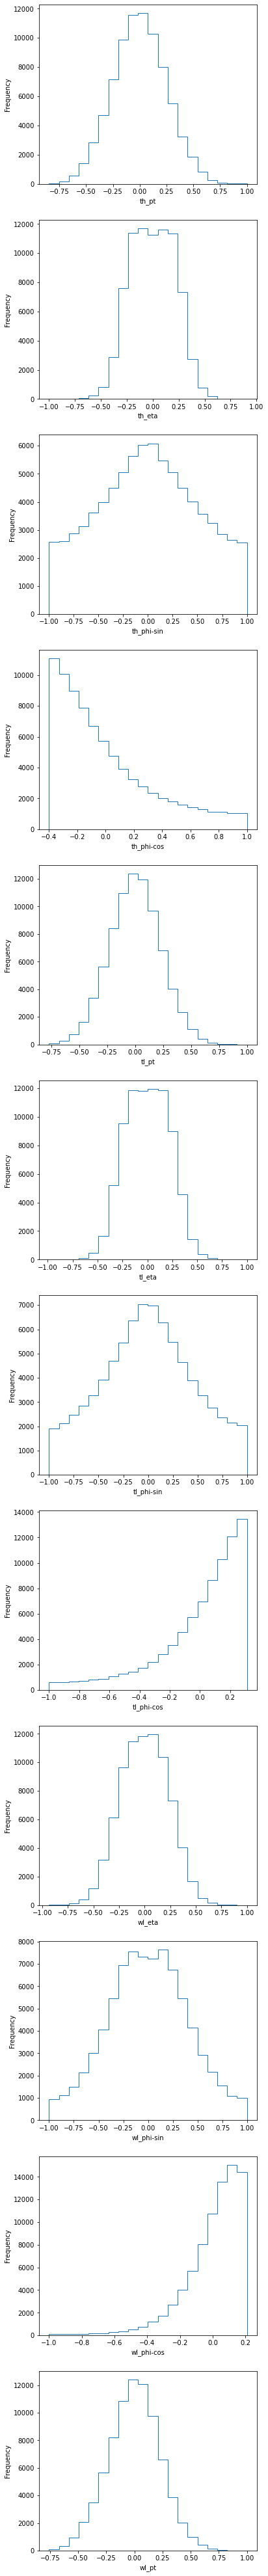

In [4]:
# Histograms of Y variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        plt.hist(trainY[:,i], 20, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

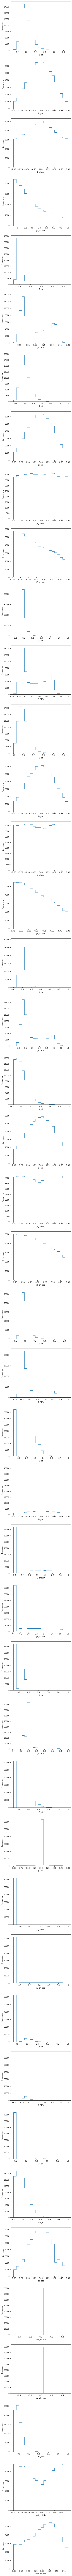

In [5]:
# Histograms of X variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainX.shape[1]))
    for i in range(0, trainX.shape[1]):
        plt.subplot(trainX.shape[1], 1, i+1)
        plt.hist(trainX[:,i], 20, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [6]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(X_names)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(Y_names),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      X_shape=[len(X_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [7]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               23040     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1

In [8]:
# Fit model

Epochs= 1024

history = model.fit(trainX, trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Train on 64000 samples, validate on 16000 samples
Epoch 1/1024
64000/64000 [==============================] - 2s 29us/sample - loss: 0.1067 - mse: 0.0986 - val_loss: 0.1049 - val_mse: 0.0968
Epoch 2/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.1063 - mse: 0.0982 - val_loss: 0.1045 - val_mse: 0.0964
Epoch 3/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.1059 - mse: 0.0978 - val_loss: 0.1041 - val_mse: 0.0961
Epoch 4/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.1056 - mse: 0.0975 - val_loss: 0.1038 - val_mse: 0.0958
Epoch 5/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.1052 - mse: 0.0972 - val_loss: 0.1035 - val_mse: 0.0955
Epoch 6/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.1049 - mse: 0.0969 - val_loss: 0.1032 - val_mse: 0.0952
Epoch 7/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.1045 - mse: 0.0965 

Epoch 116/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0654 - mse: 0.0582 - val_loss: 0.0650 - val_mse: 0.0578
Epoch 117/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0653 - mse: 0.0581 - val_loss: 0.0649 - val_mse: 0.0577
Epoch 118/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0652 - mse: 0.0580 - val_loss: 0.0649 - val_mse: 0.0577
Epoch 119/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0651 - mse: 0.0579 - val_loss: 0.0648 - val_mse: 0.0576
Epoch 120/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0651 - mse: 0.0579 - val_loss: 0.0647 - val_mse: 0.0575
Epoch 121/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0650 - mse: 0.0578 - val_loss: 0.0647 - val_mse: 0.0575
Epoch 122/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0649 - mse: 0.0577 - val_loss: 0.0646 - val_mse: 0.0574


64000/64000 [==============================] - 1s 10us/sample - loss: 0.0602 - mse: 0.0535 - val_loss: 0.0603 - val_mse: 0.0536
Epoch 231/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0602 - mse: 0.0535 - val_loss: 0.0603 - val_mse: 0.0536
Epoch 232/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0602 - mse: 0.0535 - val_loss: 0.0603 - val_mse: 0.0536
Epoch 233/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0602 - mse: 0.0535 - val_loss: 0.0602 - val_mse: 0.0535
Epoch 234/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0601 - mse: 0.0534 - val_loss: 0.0602 - val_mse: 0.0535
Epoch 235/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0601 - mse: 0.0534 - val_loss: 0.0602 - val_mse: 0.0535
Epoch 236/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0601 - mse: 0.0534 - val_loss: 0.0602 - val_mse: 0.0535
Epoch 237/1024


64000/64000 [==============================] - 1s 10us/sample - loss: 0.0577 - mse: 0.0514 - val_loss: 0.0581 - val_mse: 0.0518
Epoch 345/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0576 - mse: 0.0513 - val_loss: 0.0580 - val_mse: 0.0517
Epoch 346/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0576 - mse: 0.0513 - val_loss: 0.0580 - val_mse: 0.0517
Epoch 347/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0576 - mse: 0.0513 - val_loss: 0.0580 - val_mse: 0.0517
Epoch 348/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0576 - mse: 0.0513 - val_loss: 0.0580 - val_mse: 0.0517
Epoch 349/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0576 - mse: 0.0513 - val_loss: 0.0580 - val_mse: 0.0517
Epoch 350/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0576 - mse: 0.0513 - val_loss: 0.0580 - val_mse: 0.0517
Epoch 351/1024
6

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0558 - mse: 0.0498 - val_loss: 0.0565 - val_mse: 0.0505
Epoch 459/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0558 - mse: 0.0498 - val_loss: 0.0565 - val_mse: 0.0505
Epoch 460/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0557 - mse: 0.0498 - val_loss: 0.0565 - val_mse: 0.0505
Epoch 461/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0557 - mse: 0.0497 - val_loss: 0.0565 - val_mse: 0.0505
Epoch 462/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0557 - mse: 0.0497 - val_loss: 0.0565 - val_mse: 0.0505
Epoch 463/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0557 - mse: 0.0497 - val_loss: 0.0565 - val_mse: 0.0505
Epoch 464/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0557 - mse: 0.0497 - val_loss: 0.0565 - val_mse: 0.0505
Epoch 465/1024


64000/64000 [==============================] - 1s 9us/sample - loss: 0.0542 - mse: 0.0485 - val_loss: 0.0554 - val_mse: 0.0497
Epoch 573/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0542 - mse: 0.0485 - val_loss: 0.0554 - val_mse: 0.0497
Epoch 574/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0542 - mse: 0.0485 - val_loss: 0.0554 - val_mse: 0.0497
Epoch 575/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0542 - mse: 0.0485 - val_loss: 0.0554 - val_mse: 0.0496
Epoch 576/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0542 - mse: 0.0485 - val_loss: 0.0554 - val_mse: 0.0496
Epoch 577/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0542 - mse: 0.0484 - val_loss: 0.0554 - val_mse: 0.0496
Epoch 578/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0542 - mse: 0.0484 - val_loss: 0.0554 - val_mse: 0.0496
Epoch 579/1024
6400

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0529 - mse: 0.0474 - val_loss: 0.0546 - val_mse: 0.0490
Epoch 687/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0529 - mse: 0.0474 - val_loss: 0.0546 - val_mse: 0.0490
Epoch 688/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0529 - mse: 0.0474 - val_loss: 0.0546 - val_mse: 0.0490
Epoch 689/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0529 - mse: 0.0474 - val_loss: 0.0545 - val_mse: 0.0490
Epoch 690/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0529 - mse: 0.0474 - val_loss: 0.0545 - val_mse: 0.0490
Epoch 691/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0529 - mse: 0.0474 - val_loss: 0.0545 - val_mse: 0.0490
Epoch 692/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0529 - mse: 0.0474 - val_loss: 0.0545 - val_mse: 0.0490
Epoch 693/1024

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0519 - mse: 0.0465 - val_loss: 0.0540 - val_mse: 0.0486
Epoch 801/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0519 - mse: 0.0465 - val_loss: 0.0540 - val_mse: 0.0486
Epoch 802/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0518 - mse: 0.0465 - val_loss: 0.0539 - val_mse: 0.0486
Epoch 803/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0518 - mse: 0.0465 - val_loss: 0.0539 - val_mse: 0.0486
Epoch 804/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0518 - mse: 0.0465 - val_loss: 0.0539 - val_mse: 0.0486
Epoch 805/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0518 - mse: 0.0465 - val_loss: 0.0539 - val_mse: 0.0486
Epoch 806/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0518 - mse: 0.0465 - val_loss: 0.0539 - val_mse: 0.0486
Epoch 807/1024
6

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0509 - mse: 0.0457 - val_loss: 0.0535 - val_mse: 0.0483
Epoch 915/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0509 - mse: 0.0457 - val_loss: 0.0535 - val_mse: 0.0483
Epoch 916/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0509 - mse: 0.0457 - val_loss: 0.0535 - val_mse: 0.0483
Epoch 917/1024
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0509 - mse: 0.0457 - val_loss: 0.0535 - val_mse: 0.0483
Epoch 918/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0509 - mse: 0.0457 - val_loss: 0.0535 - val_mse: 0.0483
Epoch 919/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0509 - mse: 0.0457 - val_loss: 0.0535 - val_mse: 0.0483
Epoch 920/1024
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0509 - mse: 0.0457 - val_loss: 0.0535 - val_mse: 0.0483
Epoch 921/1024
6400

Text(0.5, 1.0, 'MSE loss')

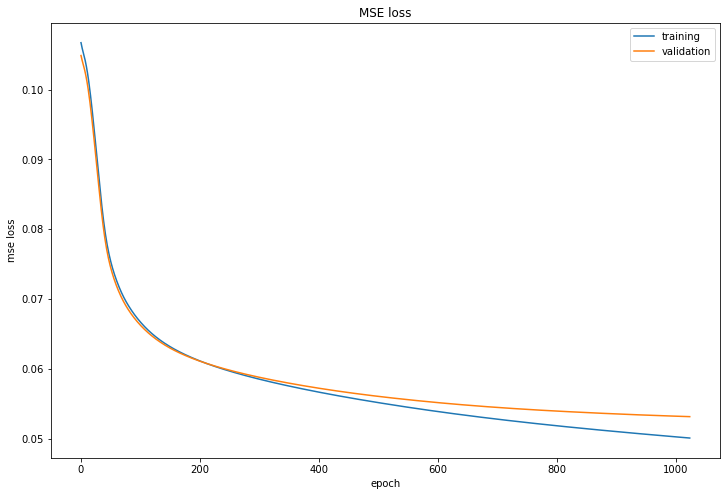

In [9]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [10]:
predictions = model.predict(testX)

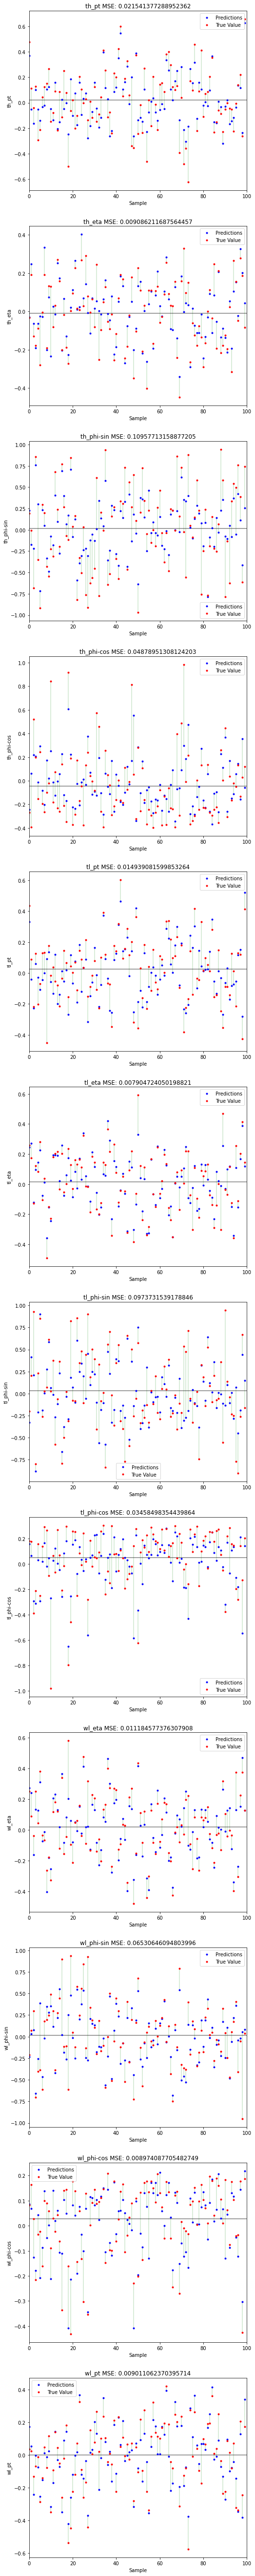

In [11]:

# Training 
crop = 100 

train_small = model.predict(trainX[0:100,:])
Y_small = trainY[0:100,:]


def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*len(Y_names)))
    for i in range(0,len(Y_names)):
        plt.subplot(len(Y_names),1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Sample')
        plt.ylabel(Y_names[i])
        plt.xlim(0, crop)
        plt.title(Y_names[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, Y_small)

In [12]:
# Predictions

predictions_small = predictions[0:100,:]
testY_small = testY[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- testY)**2)
print("total MSE: " + str(MSE))

for i in range(len(Y_names)):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -testY[:,i])**2)
    print("{0} MSE : ".format(Y_names[i]), '%.10f'%MSE)

total MSE: 0.04836454815203346
th_pt MSE :  0.0240908225
th_eta MSE :  0.0129398047
th_phi-sin MSE :  0.1697898959
th_phi-cos MSE :  0.0755931949
tl_pt MSE :  0.0178022792
tl_eta MSE :  0.0106886941
tl_phi-sin MSE :  0.1271954672
tl_phi-cos MSE :  0.0453717064
wl_eta MSE :  0.0096155445
wl_phi-sin MSE :  0.0597374163
wl_phi-cos MSE :  0.0141759045
wl_pt MSE :  0.0133738476


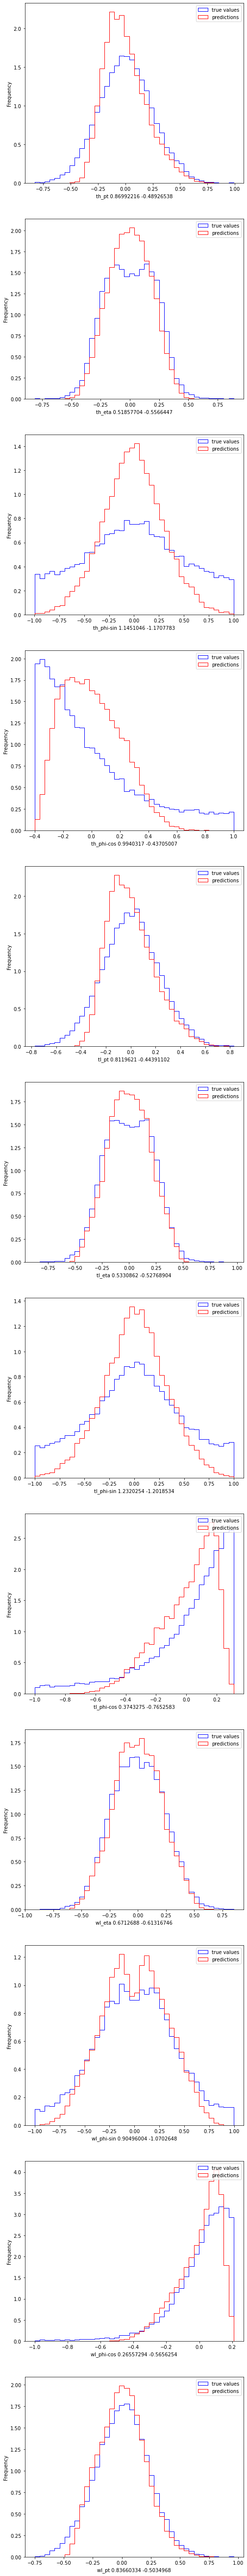

In [13]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*len(Y_names)))
for i in range(len(Y_names)):
    plt.subplot(len(Y_names), 1, i+1)
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(testY[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_names[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

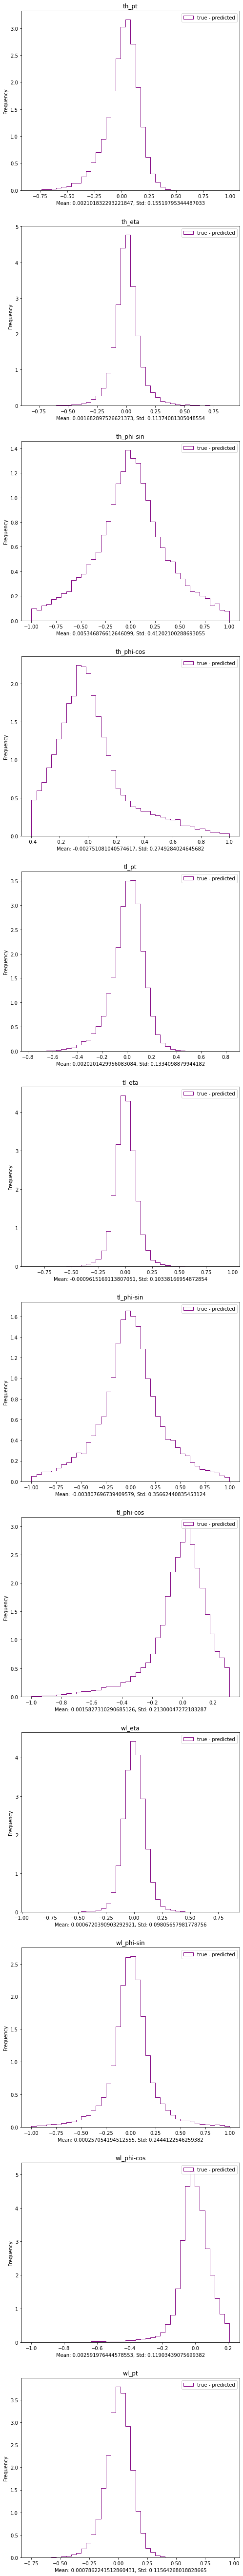

In [14]:
# True - Predicted 

plt.figure(figsize=(8,8*len(Y_names)))
for i in range(len(Y_names)):
    plt.subplot(len(Y_names), 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_names[i])
    plt.legend()
    plt.ylabel('Frequency')

In [15]:
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)
out_scaled = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

total_predictions = model.predict(X_total)
predict_scaled = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]

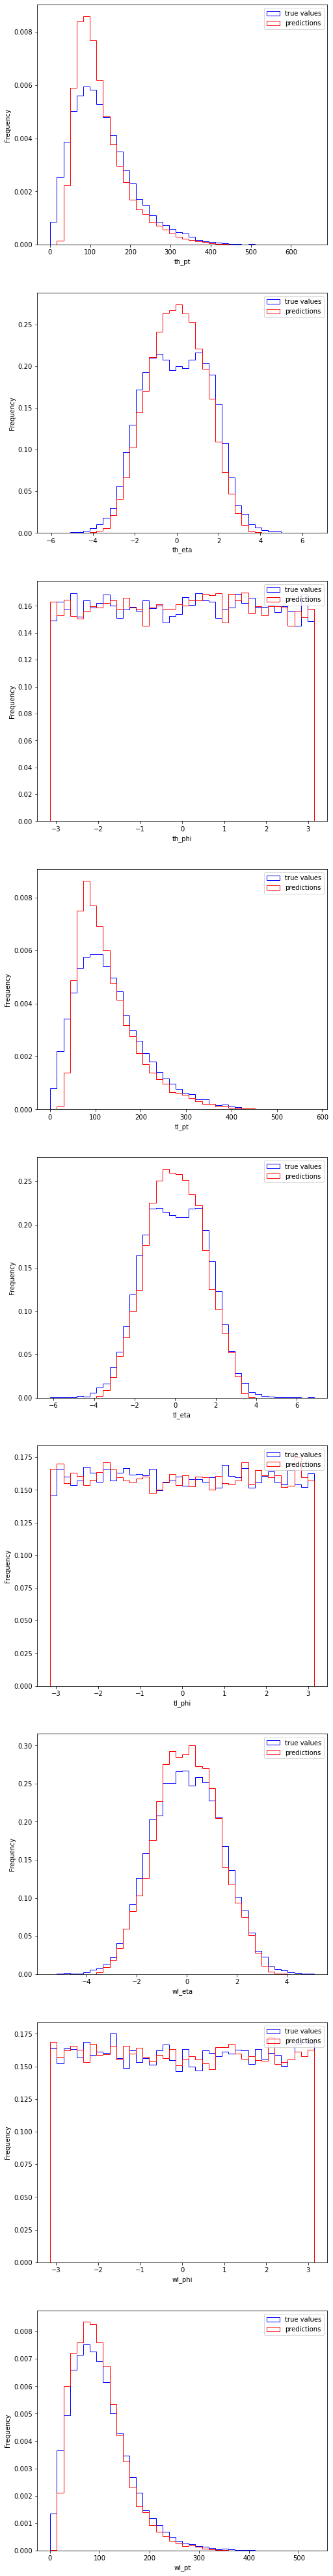

In [16]:
# Histograms to the original scale 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    hist, edges = np.histogram(out_scaled[:, i], 40)
    plt.hist(out_scaled[:, i], edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

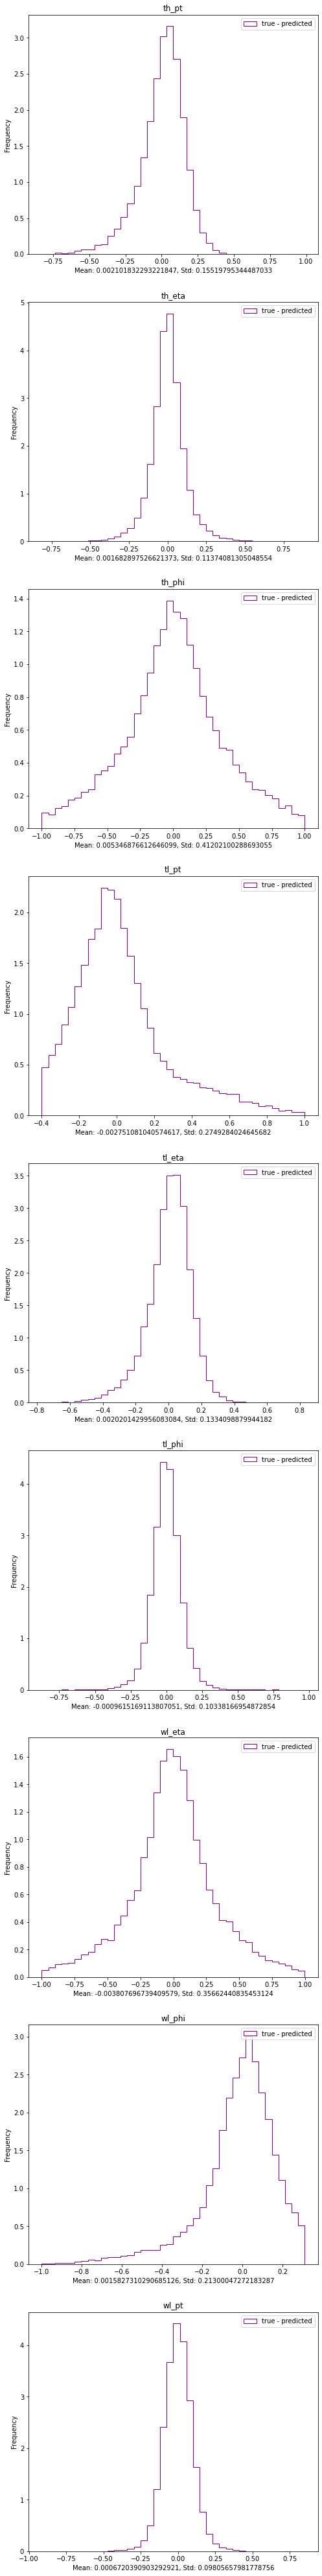

In [17]:
# True - Predicted 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

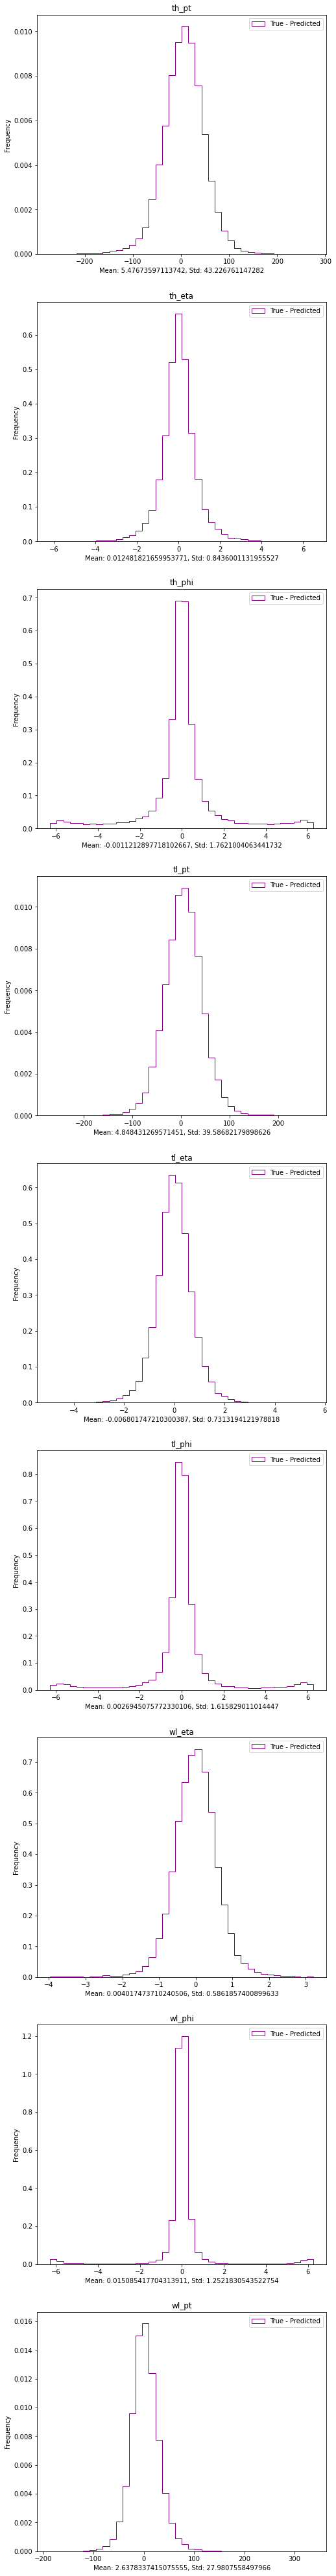

In [18]:
# Difference value histograms 
plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    diff = -predict_scaled[:, i]+out_scaled[:, i]
    plt.hist(diff, 40, histtype='step', color='purple', label='True - Predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [19]:
for i in range(Y_length):
    if Y_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(Y_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  1898.5475161817
Original Scale th_eta MSE :  0.7118169469
Original Scale th_phi MSE :  0.9372082960
Original Scale tl_pt MSE :  1590.6237459205
Original Scale tl_eta MSE :  0.5348743464
Original Scale tl_phi MSE :  0.6083277365
Original Scale wl_eta MSE :  0.3436298620
Original Scale wl_phi MSE :  0.2197057053
Original Scale wl_pt MSE :  789.8808647738


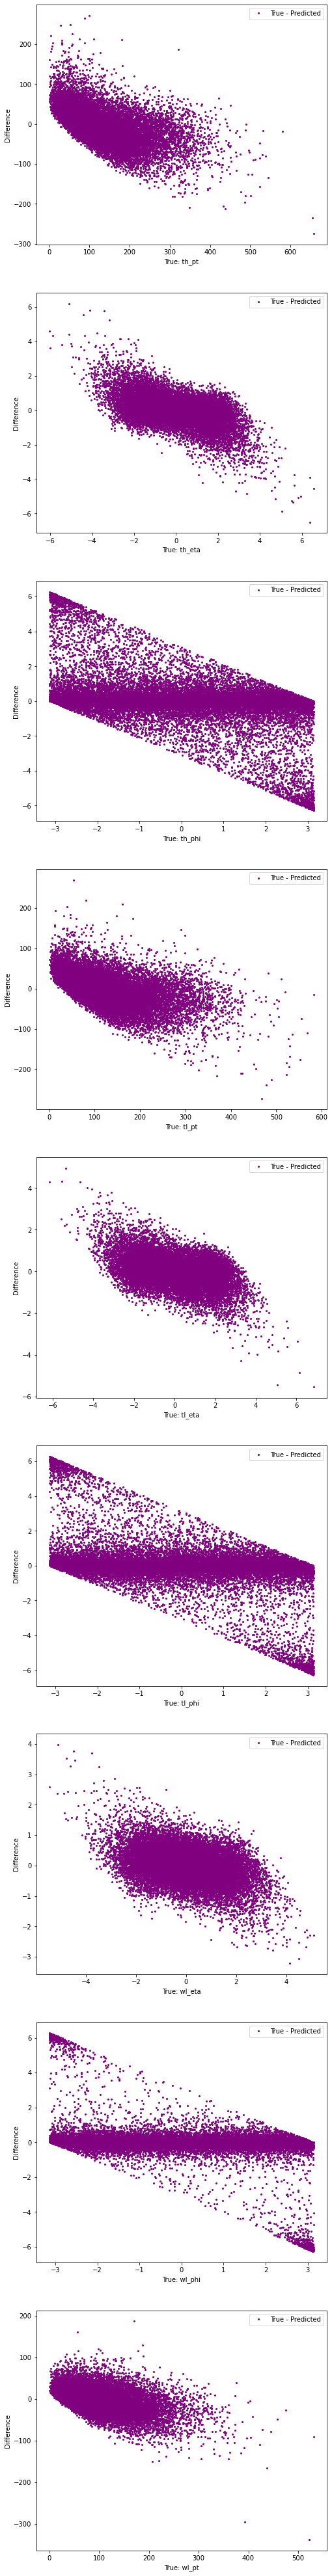

In [20]:
plt.figure(figsize=(8,8*Y_length))
for i in range(Y_length):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + Y_keys[i])
    plt.legend()
    plt.ylabel('Difference')